In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [23]:
def _make_supervised(df: pd.DataFrame, lag: int, forecast: int):
    """
    Turn a OHLCV price series into a supervised-learning matrix.

    Each row contains the flattened OHLCV values for the previous `lag`
    trading days (lag × 5 columns), and the target is the **Close**
    price `forecast` days ahead.
    """
    df = df.sort_values("Date").reset_index(drop=True)
    feats, targets = [], []

    for i in range(lag - 1, len(df) - forecast):
        window = df.loc[i - lag + 1 : i, ["Open", "High", "Low", "Close", "Volume"]]
        feats.append(window.values.flatten())
        targets.append(df.loc[i + forecast, "Close"])

    return np.asarray(feats), np.asarray(targets)

In [47]:
def run_dnn(lag, forecast, csv_file,
            hidden_layer_sizes=(128,64,32),
            max_iter=300, random_state=42):
    df = pd.read_csv(csv_file)
    df = df.sort_values('Date').reset_index(drop=True)
    df[['Open','High','Low','Close','Volume']] = df[['Open','High','Low','Close','Volume']].ffill()
    
    X, y = [], []
    for i in range(lag-1, len(df)-forecast):
        window = df.loc[i-lag+1:i, ['Open','High','Low','Close','Volume']]
        X.append(window.values.flatten())
        y.append(df.loc[i+forecast, 'Close'])
    X, y = np.array(X), np.array(y)
    
    # Chronological split: 70/15/15
    n = len(X)
    tr = int(0.70 * n)
    val = int(0.85 * n)
    X_tr, y_tr = X[:tr],        y[:tr]
    X_va, y_va = X[tr:val],     y[tr:val]
    X_te, y_te = X[val:],       y[val:]
    
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_va_s = scaler.transform(X_va)
    X_te_s = scaler.transform(X_te)
    
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                       activation='relu',
                       solver='adam',
                       learning_rate_init=1e-3,
                       max_iter=max_iter,
                       random_state=random_state)
    mlp.fit(X_tr_s, y_tr)
    
    # Predictions
    preds = {
        'train': mlp.predict(X_tr_s),
        'val':   mlp.predict(X_va_s),
        'test':  mlp.predict(X_te_s),
    }
    
    # Metrics calculation
    metrics = {}
    for split, (y_true, y_pred) in zip(
        ['train','val','test'],
        [(y_tr, preds['train']), (y_va, preds['val']), (y_te, preds['test'])]
    ):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        metrics[split] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    return metrics, mlp, scaler, (X_tr, y_tr, X_va, y_va, X_te, y_te)

In [46]:
symbols = {'AAPL': 'data/stocks/AAPL.csv', 'SPY': 'data/etfs/SPY.csv'}
records = []
models = {}

for sym, path in symbols.items():
    # Unpack all 5 return values from run_dnn
    m, model, scaler_X, scaler_y, data = run_dnn(15, 5, path, max_iter=300) # Adjusted max_iter to match later cells if needed
    # Store the model, the feature scaler (scaler_X), and the data tuple
    models[sym] = (model, scaler_X, data)
    for split, stats in m.items():
        rec = {'Symbol': sym, 'Split': split}
        rec.update(stats)
        records.append(rec)

df_metrics = pd.DataFrame(records)
# Display the metrics DataFrame
df_metrics

C:\Users\middl\AppData\Local\Temp\ipykernel_14988\2505115562.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['MA10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
C:\Users\middl\AppData\Local\Temp\ipykernel_14988\2505115562.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['MA50'] = df['Close'].rolling(window=50).mean().fillna(method='bfill')
C:\Users\middl\AppData\Local\Temp\ipykernel_14988\2505115562.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['MA10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
C:\Users\middl\AppData\Local\Temp\ipykernel_14988\2505115562.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.

,Symbol,Split,MSE,RMSE,MAE,R2
0,AAPL,train,0.001003,0.031677,0.022467,0.008844
1,AAPL,val,0.002383,0.048812,0.041883,-4.093659
2,AAPL,test,0.021569,0.146863,0.137323,-71.473067
3,SPY,train,0.000158,0.012558,0.008470,0.001950
4,SPY,val,0.000073,0.008538,0.006413,-0.032759
5,SPY,test,0.000175,0.013237,0.009357,-0.327152


Text(0, 0.5, 'Loss')

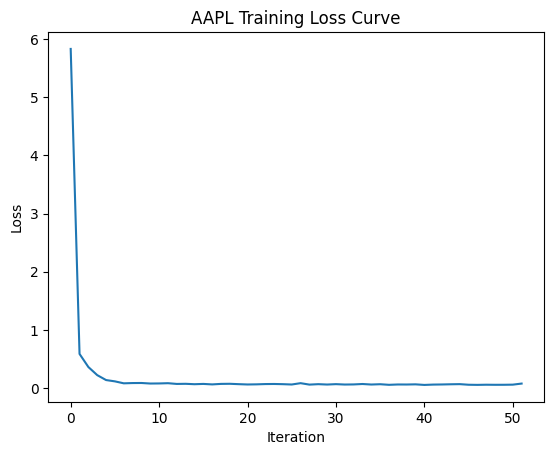

In [29]:
model_a, scaler_a, data_a = models['AAPL']
loss_curve = model_a.loss_curve_

plt.figure()
plt.plot(loss_curve)
plt.title('AAPL Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

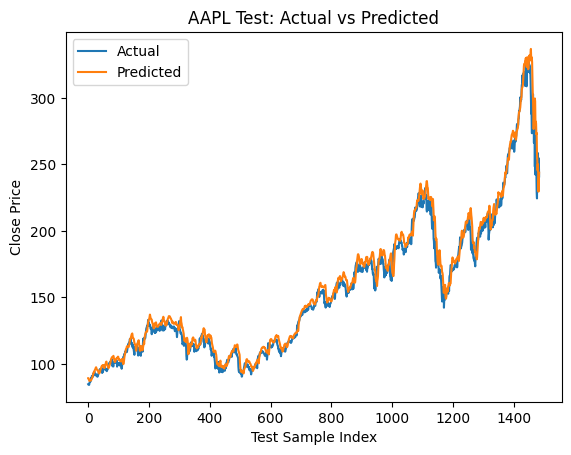

In [30]:
X_tr, y_tr, X_va, y_va, X_te, y_te = data_a
y_te_pred = model_a.predict(scaler_a.transform(X_te))

plt.figure()
plt.plot(y_te, label='Actual')
plt.plot(y_te_pred, label='Predicted')
plt.title('AAPL Test: Actual vs Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('Close Price')
plt.legend()

plt.show()